<a href="https://colab.research.google.com/github/Oreksandero/python_mate/blob/master/Python_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Встановлення останньої версії google-cloud-bigquery
!pip install --upgrade google-cloud-bigquery

# Імпорт бібліотек
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

In [ ]:
# Аутентифікація в Google Colab для доступу до BigQuery
auth.authenticate_user()

# Створення клієнта BigQuery для проєкту "data-analytics-mate"
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
# SQL запит для створення датасету
query = """
SELECT
  sesh.ga_session_id AS session_id,
  sesh.date AS order_date,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.medium,
  sp.name,
  sp.channel,
  ac.id AS registered_account_id,
  ac.is_verified,
  ac.is_unsubscribed,
  prd.category,
  prd.name as product_name,
  prd.price,
  prd.short_description
FROM `data-analytics-mate.DA.session` sesh
INNER JOIN `data-analytics-mate.DA.order` ordr
  ON ordr.ga_session_id = sesh.ga_session_id
LEFT JOIN `data-analytics-mate.DA.session_params` sp
  ON sesh.ga_session_id = sp.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account_session` acs
  ON sesh.ga_session_id = acs.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account` ac
  ON acs.account_id = ac.id
LEFT JOIN `data-analytics-mate.DA.product` prd
  ON ordr.item_id = prd.item_id
"""

In [ ]:
# Виконання запит та перетворення результатів у pandas DataFrame
df = client.query(query).to_dataframe()

# Конвертування колонки order_date у тип datetime
df['order_date'] = pd.to_datetime(df['order_date'])

In [ ]:
# Виведення перших 5 рядків DataFrame
print(df.head())

   session_id order_date continent        country   device browser  \
0   967742695 2020-11-01  Americas  United States  desktop  Safari   
1  9065007548 2020-11-01      Asia          China  desktop  Chrome   
2  3267062634 2020-11-01  Americas  United States  desktop  Chrome   
3  5483849751 2020-11-01  Americas  United States  desktop  Safari   
4  9254546338 2020-11-01    Europe        Ireland   mobile  Chrome   

  mobile_model_name operating_system language          medium            name  \
0            Safari              Web    en-us  (data deleted)  (data deleted)   
1            Safari              Web     None  (data deleted)  (data deleted)   
2            Safari              Web    en-us  (data deleted)  (data deleted)   
3            Safari              Web     None  (data deleted)  (data deleted)   
4           <Other>              Web    en-us  (data deleted)  (data deleted)   

     channel  registered_account_id  is_verified  is_unsubscribed  \
0  Undefined           

In [ ]:
# Перевірка типів даних
print("\nТипи даних у датасеті:")
print(df.dtypes)

# Загальна кількість колонок
total_columns = df.shape[1]
print("Загальна кількість колонок:", total_columns)

# Визначення числових колонок
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print("Кількість числових колонок:", len(numeric_cols))
print("Числові колонки:", numeric_cols)

# Визначення категоріальних колонок
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Кількість категоріальних колонок:", len(categorical_cols))
print("Категоріальні колонки:", categorical_cols)

# Визначення datetime колонок
datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
print("Кількість колонок типу datetime:", len(datetime_cols))


Типи даних у датасеті:
session_id                        Int64
order_date               datetime64[ns]
continent                        object
country                          object
device                           object
browser                          object
mobile_model_name                object
operating_system                 object
language                         object
medium                           object
name                             object
channel                          object
registered_account_id             Int64
is_verified                       Int64
is_unsubscribed                   Int64
category                         object
product_name                     object
price                           float64
short_description                object
dtype: object
Загальна кількість колонок: 19
Кількість числових колонок: 5
Числові колонки: ['session_id', 'registered_account_id', 'is_verified', 'is_unsubscribed', 'price']
Кількість категоріальних колонок: 13
Кате

In [ ]:
# Кількість унікальних сесій
if 'session_id' in df.columns:
    unique_sessions = df['session_id'].nunique()
    print("Кількість унікальних сесій:", unique_sessions)

# Визначення періоду часу, який охоплює датафрейм (від мінімальної до максимальної дати)
if datetime_cols:
    date_col = datetime_cols[0]
    start_date = df[date_col].min()
    end_date = df[date_col].max()
    print(f"Період часу ({date_col}): від {start_date} до {end_date}")

Кількість унікальних сесій: 33538
Період часу (order_date): від 2020-11-01 00:00:00 до 2021-01-27 00:00:00


In [ ]:
# Перевірка наявності пропущених значень у датасеті
def missing_stats(df):

    total_missing = df.isnull().sum()
    percent_missing = (df.isnull().sum() / len(df)) * 100
    missing_df = pd.DataFrame({
        'Total Missing': total_missing,
        'Percentage Missing': percent_missing
    })

    missing_df = missing_df[missing_df['Total Missing'] > 0]
    return missing_df

print("Пропущені значення в датасеті:")
print(missing_stats(df))

Пропущені значення в датасеті:
                       Total Missing  Percentage Missing
language                       11007           32.819488
registered_account_id          30757           91.707913
is_verified                    30757           91.707913
is_unsubscribed                30757           91.707913


In [ ]:
# 1. Визначення топ 5 країн та топ 10 категорій за доходом
country_sales = df.groupby('country')['price'].sum().sort_values(ascending=False)

top_5_countries = country_sales.head(5)
print("Топ-5 країн за доходом:")
print(top_5_countries)

top_country = top_5_countries.index[0]
print(f"\nКраїна з найбільшими продажами: {top_country}")

df_top_country = df[df['country'] == top_country]

top_categories = df_top_country.groupby('category')['price'].sum().sort_values(ascending=False).head(10)

print("\nТоп-10 категорій для країни з найбільшими продажами:")
print(top_categories)

Топ-5 країн за доходом:
country
United States     13943553.9
India              2809762.0
Canada             2437921.0
United Kingdom      938317.9
France              710692.8
Name: price, dtype: float64

Країна з найбільшими продажами: United States

Топ-10 категорій для країни з найбільшими продажами:
category
Sofas & armchairs                   3707144.5
Chairs                              2619773.8
Beds                                2213058.0
Bookcases & shelving units          1567606.9
Cabinets & cupboards                 994545.5
Outdoor furniture                    929245.2
Tables & desks                       777865.0
Chests of drawers & drawer units     382388.0
Bar furniture                        330805.0
Children's furniture                 207575.0
Name: price, dtype: float64


In [ ]:
# Топ 3 категорії серед топ 5 країн за доходом
df_top5 = df[df['country'].isin(top_5_countries.index)]

country_category_sales = df_top5.groupby(['country', 'category'])['price'].sum().reset_index()

country_category_sales = country_category_sales.sort_values(['country', 'price'], ascending=[True, False])

top_3_categories_top5 = country_category_sales.groupby('country').head(3)

print("\nТоп-3 категорії для кожної з топ-5 країн за доходом:")
print(top_3_categories_top5)


Топ-3 категорії для кожної з топ-5 країн за доходом:
           country                    category      price
12          Canada           Sofas & armchairs   692427.5
5           Canada                      Chairs   417740.8
1           Canada                        Beds   354772.0
26          France           Sofas & armchairs   187735.0
19          France                      Chairs   134029.4
15          France                        Beds   116414.0
40           India           Sofas & armchairs   788430.0
33           India                      Chairs   544309.2
30           India  Bookcases & shelving units   364507.4
54  United Kingdom           Sofas & armchairs   234812.0
47  United Kingdom                      Chairs   188519.4
43  United Kingdom                        Beds   133816.0
68   United States           Sofas & armchairs  3707144.5
61   United States                      Chairs  2619773.8
57   United States                        Beds  2213058.0


У всіх топ п'яти країнах за обсягом доходу перші три категорії співпадають(Sofas & armchairs, Chairs, Beds), за винятком третього місця в Індії. Там це категорія **Bookcases** **&** **shelving** **units**, замість **Beds**.

In [ ]:
# Топ‑5 країн за кількістю та відсотком зареєстрованих користувачів
registered = df[df['registered_account_id'].notnull()]

country_counts = registered.groupby('country')['registered_account_id'].nunique()

total_registered = country_counts.sum()

top5_counts = country_counts.sort_values(ascending=False).head(5)

top5_pct = (top5_counts / total_registered * 100).round(2)

top5_summary = pd.DataFrame({
    'count': top5_counts,
    'percentage': top5_pct
})

print("Топ‑5 країн за кількістю та часткою зареєстрованих користувачів:")
print(top5_summary)

Топ‑5 країн за кількістю та часткою зареєстрованих користувачів:
                count  percentage
country                          
United States    1207       43.40
India             246        8.85
Canada            207        7.44
United Kingdom     88        3.16
France             56        2.01


<ipython-input-28-94325d6eb157>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M').sum()


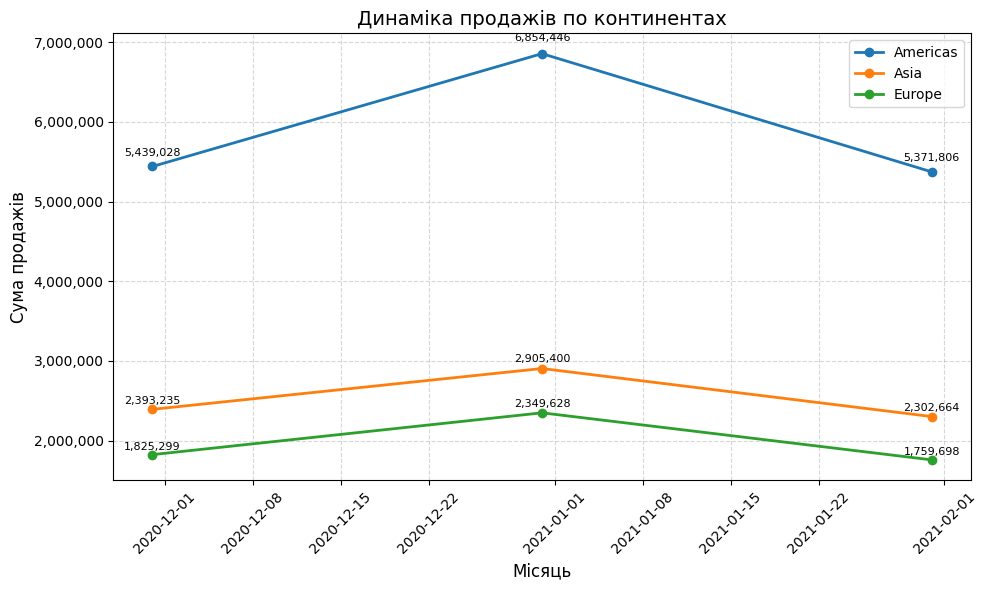

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter # бібліотеки для візуалізацій

continents = ['Americas', 'Asia', 'Europe']

df2 = df[df['continent'].isin(continents)].set_index('order_date')
sales_monthly = (df2.groupby('continent')['price']
                   .resample('M').sum()
                   .unstack('continent'))

# побудова графіку
fig, ax = plt.subplots(figsize=(10,6))
for cont in continents:
    ax.plot(sales_monthly.index, sales_monthly[cont],
            marker='o', linewidth=2, label=cont)
    # підписи над точками
    for x, y in zip(sales_monthly.index, sales_monthly[cont]):
        ax.text(x, y*1.02, f'{y:,.0f}',
                ha='center', va='bottom', fontsize=8)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

ax.set_title('Динаміка продажів по континентах', fontsize=14)
ax.set_xlabel('Місяць', fontsize=12)
ax.set_ylabel('Сума продажів', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Усі континенти показують зростання продажів до початку січня 2021 року, після чого було помітне зниження. Найвищі обсяги стабільно демонстрували **Americas**.

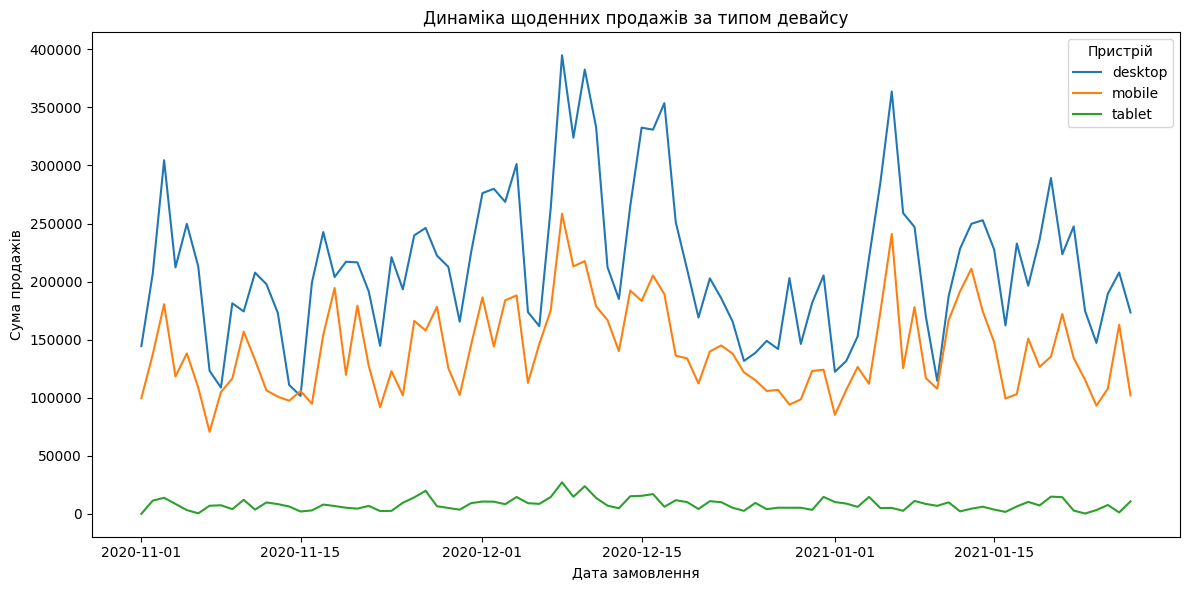

In [ ]:
# Агрегування продажів за днями в розрізі девайсів
sales_ts = (
    df
    .set_index('order_date')
    .groupby([pd.Grouper(freq='D'), 'device'])['price']
    .sum()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 6))
for device in sales_ts.columns:
    plt.plot(sales_ts.index, sales_ts[device], label=device)
plt.xlabel('Дата замовлення')
plt.ylabel('Сума продажів')
plt.title('Динаміка щоденних продажів за типом девайсу')
plt.legend(title='Пристрій')
plt.tight_layout()
plt.show()

In [ ]:
# Зведена таблиця з доходом і кількістю сесій на день
pivot_sales = df.pivot_table(
    values=['price', 'session_id'],   # Обидві метрики
    index='order_date',
    aggfunc={
        'price': 'sum',               # Сума доходу
        'session_id': pd.Series.nunique  # Кількість унікальних сесій
    },
    fill_value=0
)

pivot_sales.columns = ['total_revenue', 'unique_sessions']  # Опціонально перейменуємо колонки
print(pivot_sales.head())

            total_revenue  unique_sessions
order_date                                
2020-11-01       244292.5              281
2020-11-02       355506.8              368
2020-11-03       498979.6              561
2020-11-04       339187.1              370
2020-11-05       391276.6              388


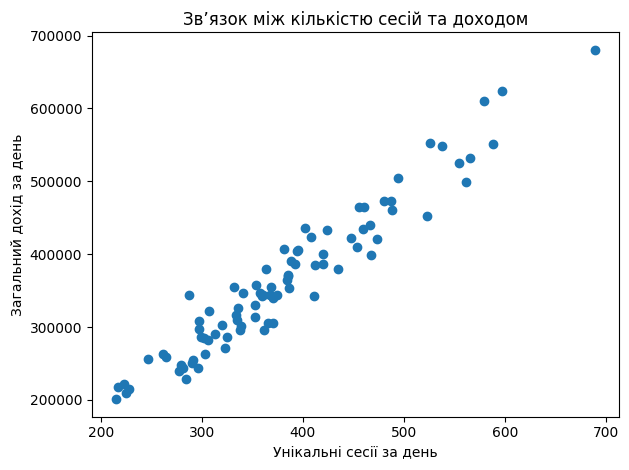

In [ ]:
plt.figure()
plt.scatter(pivot_sales['unique_sessions'], pivot_sales['total_revenue'])
plt.xlabel('Унікальні сесії за день')
plt.ylabel('Загальний дохід за день')
plt.title('Зв’язок між кількістю сесій та доходом')
plt.tight_layout()
plt.show()

Одразу видно дуже тісну позитивну кореляцію - що більше сесій - то більше доходу

In [ ]:
# порахуємо коефіцієнт кореляції Пірсона
corr = pivot_sales['unique_sessions'].corr(pivot_sales['total_revenue'])
print(f"Коефіцієнт кореляції Пірсона: {corr:.2f}")

Коефіцієнт кореляції Пірсона: 0.96


тест Пірсона підтвердив дуже сильну пряму кореляцію

In [ ]:
# кількість сесій у розрізі каналу
session_counts = df.groupby('channel')['session_id'].nunique()

session_counts = session_counts.sort_values(ascending=False)

session_pct = (session_counts / session_counts.sum() * 100).round(2)

traffic_summary = pd.DataFrame({
    'sessions': session_counts,
    'percentage': session_pct
})

print(traffic_summary)

                sessions  percentage
channel                             
Organic Search     11921       35.54
Paid Search         9042       26.96
Direct              7800       23.26
Social Search       2716        8.10
Undefined           2059        6.14


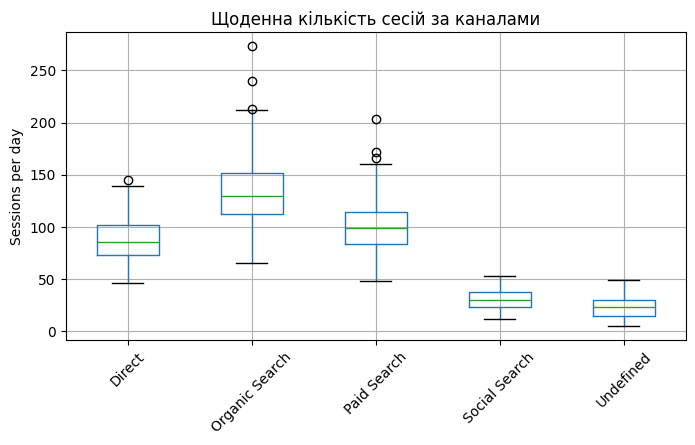

Shapiro–Wilk (normality) per channel:
 Direct         : W=0.975, p=0.093
 Organic Search : W=0.950, p=0.002
 Paid Search    : W=0.954, p=0.003
 Social Search  : W=0.970, p=0.039
 Undefined      : W=0.973, p=0.060

Levene’s test for equal variances: stat=25.292, p=0.000

Kruskal–Wallis H‑test: stat=349.425, p=0.000
→ Відмінності між принаймні двома каналами статистично значущі (p < 0.05).


In [ ]:
from scipy.stats import shapiro, levene, f_oneway, kruskal

# 1) Зібрати щоденні counts
daily = (
    df
    .groupby(['order_date','channel'])['session_id']
    .nunique()
    .unstack(fill_value=0)     # кожна колонка = канал, індекс = дата
)

# 2) Візуалізувати розподіли
plt.figure(figsize=(8,4))
daily.boxplot(rot=45)
plt.title("Щоденна кількість сесій за каналами")
plt.ylabel("Sessions per day")
plt.show()

# 3) Перевірити нормальність і гомогенність
print("Shapiro–Wilk (normality) per channel:")
for ch in daily.columns:
    W, p = shapiro(daily[ch])
    print(f" {ch:15s}: W={W:.3f}, p={p:.3f}")

stat, p_levene = levene(*[daily[ch] for ch in daily.columns])
print(f"\nLevene’s test for equal variances: stat={stat:.3f}, p={p_levene:.3f}")

# 4) Вибір тесту
alpha = 0.05
if all(shapiro(daily[ch])[1] > alpha for ch in daily.columns) and p_levene > alpha:
    # ANOVA
    stat, p_val = f_oneway(*[daily[ch] for ch in daily.columns])
    test_name = "One‑way ANOVA"
else:
    # Непараметричний Kruskal–Wallis
    stat, p_val = kruskal(*[daily[ch] for ch in daily.columns])
    test_name = "Kruskal–Wallis H‑test"

print(f"\n{test_name}: stat={stat:.3f}, p={p_val:.3f}")

# 5) Висновок
if p_val < alpha:
    print("→ Відмінності між принаймні двома каналами статистично значущі (p < 0.05).")
else:
    print("→ Немає підстав вважати, що канали відрізняються (p ≥ 0.05).")

Розподіл щоденної кількості сесій значно різниться залежно від каналу трафіку. Деякі канали (насамперед Organic Search) приносять більше сесій, ніж інші. Direct і Paid Search мають схожий середній результат між собою, але обидва перевершують Social та Undefined. Соціальний трафік, у свою чергу, теж значно перевищує невизначений. Таким чином, принаймні частина пар каналів має статистично підтверджені відмінності у відвідуваності.